# SOHO synoptic and CHs maps

In this notebook we construct SOHO/EIT synoptic maps following the pipeline elaborated for SDO/AIA images. For SOHO/EIT synoptic maps in 195 A we apply coronal holes (CHs) identification model and compare results with CHs identified in SDO/AIA synoptic maps.

### Contents
* [Construction of synoptic maps](#Construction-of-synoptic-maps)
* [CHs segmentation](#CHs-segmentation)
* [SDO and SOHO comparison](#SDO-and-SOHO-comparison)

General imports:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
import tensorflow as tf
import sunpy.map
from sunpy.visualization.colormaps import color_tables as ct
from astropy import units as u
sdoaia193 = ct.aia_color_table(193*u.angstrom)

sys.path.append('..')
from helio.helio import HelioBatch, FilesIndex, BatchSampler, u_net, detect_edges

## Construction of synoptic maps

Index SOHO/EIT images:

In [2]:
images = FilesIndex(img='../../soho/*.jpg')
index = images.parse_datetime().get_sun_params().set_index('CR')
index

,img,DateTime,L0,B0
CR,,,,
2227,../../soho\20200204_011346.jpg,2020-02-04 01:13:46,342.475570,-6.189080
2227,../../soho\20200204_131347.jpg,2020-02-04 13:13:47,335.892192,-6.222350
2227,../../soho\20200205_011346.jpg,2020-02-05 01:13:46,329.309086,-6.255126
2227,../../soho\20200205_131346.jpg,2020-02-05 13:13:46,322.725794,-6.287409
2227,../../soho\20200206_011349.jpg,2020-02-06 01:13:49,316.142010,-6.319195
...,...,...,...,...
2229,../../soho\20200328_131347.jpg,2020-03-28 13:13:47,357.628087,-6.706969
2229,../../soho\20200329_011347.jpg,2020-03-29 01:13:47,351.033180,-6.682880
2229,../../soho\20200329_131347.jpg,2020-03-29 13:13:47,344.438067,-6.658301


Select the Carrington rotation numbers for processing:

In [3]:
index = index.loc[2228].copy()

There are multiple images per day. To keep a single image per day we drop duplicated dates:

In [4]:
index['Date'] = index['DateTime'].dt.date
index = index.drop_duplicates('Date')
len(index)

28

Define and run a pipeline for synoptic maps construction:

In [5]:
batch_sampler = BatchSampler(index, batch_size=1)

def reduce_r(meta): #recommended correction for Hough radius
    meta['r'] -= 1
    return meta
    
for ids in tqdm(batch_sampler):
    batch = (HelioBatch(ids).load('img', as_gray=True)
             .get_radius(src='img', hough_radii=np.arange(360, 390), sigma=2)
             .apply_meta(reduce_r, src='img')
             .map_to_synoptic(src='img', dst='syn', bins=(720, 360))
             .group_by_index()
             .stack_synoptic_maps(src='syn', dst='stacked', shift=13.2, scale=2)
             .match_histogram(src='stacked', reference='syn')
    )

100%|███████████████████████████████████████████████████████████████| 1/1 [02:56<00:00, 176.36s/it]


Plot the synoptic map constructed (note the SDO/AIA 193A color scheme is used for SOHO/EIT 195A data):

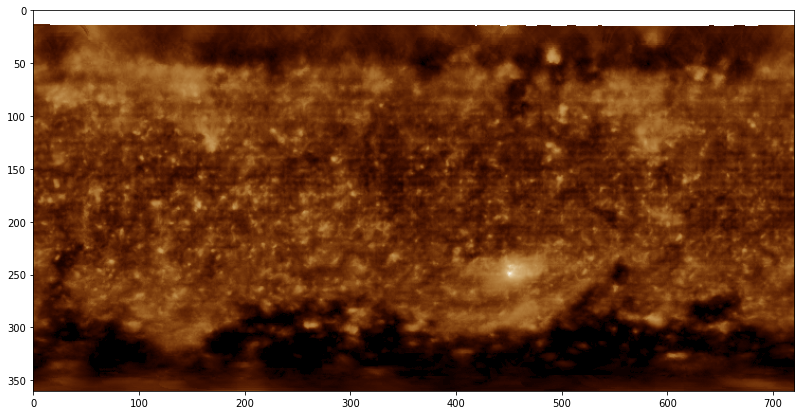

In [6]:
batch.show(0, image='stacked', cmap=sdoaia193, figsize=(14, 7))

Dump the synoptic map in a FITS file:

In [7]:
batch.dump(src='stacked', path='./maps_eit', format='fits', kind='synoptic',
           WAVELNTH=195.0, WAVEUNIT='angstrom', TELESCOP='SOHO/EIT')

## CHs segmentation

Next step is to identify CHs. First we index SOHO/EIT synoptic maps:

In [8]:
index = FilesIndex(syn='./maps_eit/*fits')
index

,syn
FilesIndex,
2228,./maps_eit\2228.fits


Then we initialize the segmentation model:

In [10]:
PATH_TO_SAVED_MODEL = "../../model_dumps/h_seg_model_24.ckpt"

image_shape = (256, 512, 1)

depth = 4 #Depth of u-net network
init_filters = 24 #Number of filters int the first conv layer

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, ) + image_shape, name='images')
    is_training = tf.placeholder(tf.bool, name='is_training')

    predict = u_net(images, depth=depth, init_filters=init_filters,
                    output={'layout': 'ca', 'filters': 1, 'activation': tf.nn.sigmoid},
                    is_training=is_training, verbose=1)

    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, PATH_TO_SAVED_MODEL)

INFO:tensorflow:Restoring parameters from ../../model_dumps/h_seg_model_24.ckpt


This is the same data processing pipeline as for SDO/AIA:

In [11]:
roi_shape = (180, 360)
r = 10
reflect_pad = np.array([[0, 0], [r, r]])
constant_pad = (np.array(image_shape[:2]) - np.array(roi_shape)) // 2 - reflect_pad.T
constant_pad = constant_pad.T

roi_slice = tuple(slice(x, -x) for x in (np.array(image_shape[:2]) - np.array(roi_shape)) // 2)
 
def preprocess(batch):
    return (batch.load(src='syn', meta='syn')
            .fillna(src='syn', value=1.)
            .flip(src='syn', axis=0) # for FITS data
            .apply(lambda x: x.copy(), src='syn', dst='syn_full')
            .resize(src='syn', output_shape=roi_shape, preserve_range=True)      
            .apply(np.pad, src='syn', dst='syn_pad', pad_width=reflect_pad, mode='reflect')
            .apply(np.pad, src='syn_pad', pad_width=constant_pad, mode='constant', constant_values=1)
           )

Run the segmentation pipeline:

In [14]:
batch_sampler = BatchSampler(index, batch_size=10, n_epochs=1, shuffle=False, drop_incomplete=False)

for ids in tqdm(batch_sampler):
    batch = preprocess(HelioBatch(ids))
    
    inputs = np.array([np.atleast_3d(x) for x in batch.syn_pad])
    out = sess.run(predict, feed_dict={images: inputs, is_training: False})

    batch.mask = out[:, roi_slice[0], roi_slice[1], 0]
    batch.resize(src='mask', output_shape=(360, 720), preserve_range=True)
    batch.apply(lambda x: np.where(detect_edges(np.rint(x) == 1)), src='mask', dst='pts')
    batch.dump(src='mask', path='./maps_eit_chs',
               meta='syn', format='fits', kind='synoptic_mask')

100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Show the CHs identified:

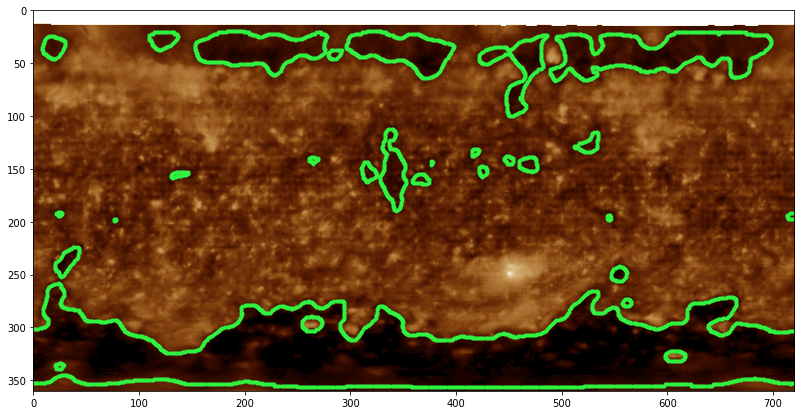

In [18]:
batch.show(0, image='syn_full', mask='mask', s=8, color='#30f241',
           figsize=(14, 7), cmap=sdoaia193)

## SDO and SOHO comparison

Finally, we compare CHs identified in SDO/AIA and SOHO/EIT synoptic maps.

To process multiple data in a single batch, we prepare a joint index based on the Carrington rotation numbers:

In [21]:
i1 = FilesIndex(soho='./maps_eit/*')
i1['CR'] = i1.index.map(lambda x: int(''.join(filter(str.isdigit, x))))
i2 = FilesIndex(soho_ch='./maps_eit_chs/*')
i2['CR'] = i2.index.map(lambda x: int(''.join(filter(str.isdigit, x))))
i3 = FilesIndex(aia='./maps_aia/aia193*')
i3['CR'] = i3.index.map(lambda x: int(''.join(filter(str.isdigit, x[6:]))))
i4 = FilesIndex(aia_ch='./maps_aia/chs*')
i4['CR'] = i4.index.map(lambda x: int(''.join(filter(str.isdigit, x))))
index = (i1.set_index('CR')
         .index_merge(i2.set_index('CR'))
         .index_merge(i3.set_index('CR'))
         .index_merge(i4.set_index('CR')))
index

,soho,soho_ch,aia,aia_ch
CR,,,,
2228,./maps_eit\2228.fits,./maps_eit_chs\2228.fits,./maps_aia\aia193_synmap_cr2228.fits,./maps_aia\chs_synmap_cr2228.fits


Load and preprocess data in a single pipeline:

In [25]:
batch = (HelioBatch(index).load(src=('soho', 'aia', 'aia_ch', 'soho_ch'))
         .flip(src=('soho', 'aia', 'aia_ch', 'soho_ch'), axis=0)
         .apply(lambda x: x>0.5, src=('aia_ch', 'soho_ch'))
         .filter_regions(src=('aia_ch', 'soho_ch'), min_area=256))

Now we show SOHO/EIT image in the background, green lines show CHs identified in the SOHO/EIT sinoptic map, blue lines show CHs identified in the SDO/AIA sinoptic map:

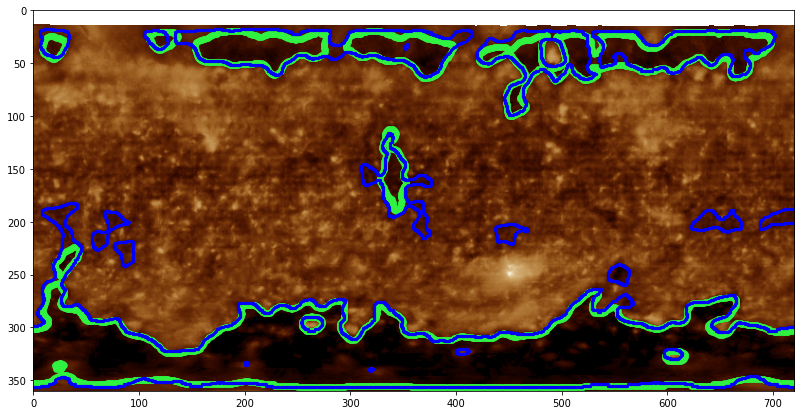

In [26]:
batch.show(0, image='soho', mask=('soho_ch', 'aia_ch'), s=(30, 5), color=('#30f241', 'blue'),
           figsize=(14, 7), cmap=sdoaia193)

In the next figure, SDO/AIA is in the background, CHs color scheme is the same as in the previous figure:

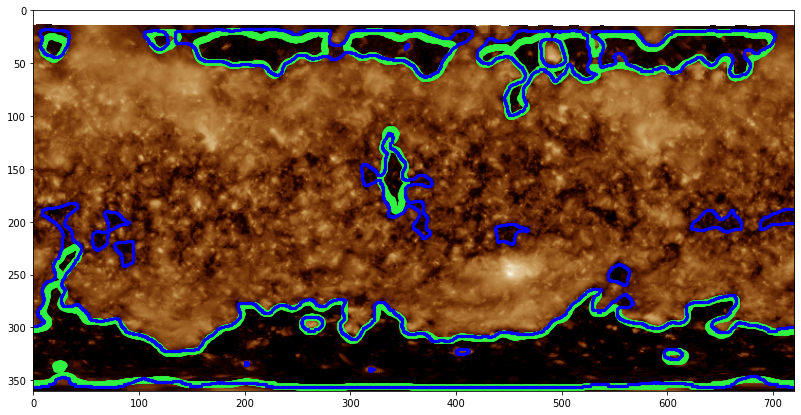

In [27]:
batch.show(0, image='aia', mask=('soho_ch', 'aia_ch'), s=(30, 5), color=('#30f241', 'blue'),
           figsize=(14, 7), cmap=sdoaia193)

We note that CHs identification in SOHO/EIT is very close to SDO/AIA one. In particular, the IOU metrics (area of intersection / area of union) is

In [32]:
iou = (batch.soho_ch[0] & batch.aia_ch[0]).sum() / (batch.soho_ch[0] | batch.aia_ch[0]).sum()
print('%.2f' % iou)

0.83


Done!